# Criando um dataset de reconstrução

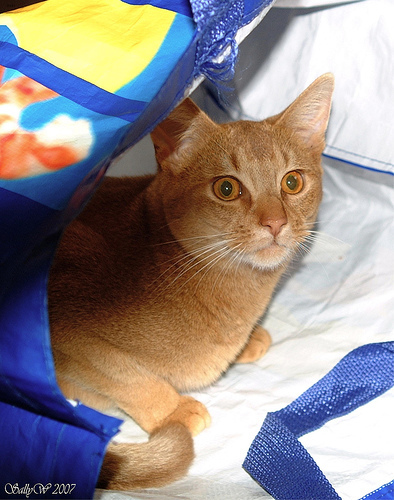

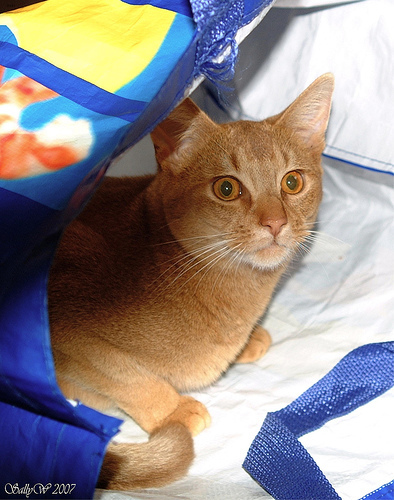

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision.transforms.v2 as transf
from torchvision import tv_tensors

# Gambiarra para importar as funções de dataset feitas anteriormente
import sys
sys.path.insert(0, '../')
from M08_classificacao_de_imagens_naturais.dataset import OxfordIIITPet

class OxfordIIITPetAe(OxfordIIITPet):
    """Modifiação da classe OxfordIIITPet para retornar a imagem de entrada
    como target."""

    def __init__(self, root):
        super().__init__(root)

    def __getitem__(self, idx):
        # Chama o método .__getitem__ da classe pai e ignora o target
        image, _ = super().__getitem__(idx)
        # Retorna duas vezes a mesma imagem
        return image, image


ds = OxfordIIITPetAe('../data/oxford_pets')
display(*ds[0])

### Adicionando ruído em imagens

Vamos criar uma transformação que adiciona ruído em imagens

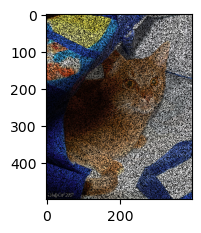

In [2]:
class AddNoise:

    def __init__(self, p_range):
        """
        Args:
            p_range (tuple): valor mínimo e máximo da probabilidade de remover um pixel.
        """

        self.p_range = p_range

    def __call__(self, img):

        p_range = self.p_range
        # Sorteia probabilidade de remoção global no intervalo (p_range[0], p_range[1])
        prob = (p_range[1]-p_range[0])*torch.rand(()) + p_range[0]
        # Gera matriz 2D 
        prob_mat = torch.full(img.shape[-2:], prob)
        # Para cada pixel, sorteia o valor 1 com probabilidade prob
        # e o valor 0 com probabilidade 1-prob
        noise = torch.bernoulli(prob_mat)
        out = img*noise

        return out

def show_img(img, normalize=True, ax=None):
    
    if normalize:
        img /= 255.

    if ax is None:
        fig, ax = plt.subplots(1,1)
    ax.imshow(img.permute(1, 2, 0))

add_noise = AddNoise((0.5, 1.))
img = transf.functional.pil_to_tensor(ds[0][0])
img_noise = add_noise(img)
show_img(img_noise)

### Transformações de treinamento

As transformações de treinamento irão incluir resize e adição de ruído.

Adicionalmente, veremos mais adiante que em tarefas de reconstrução de imagens é importante que a saída da rede esteja normalizada no intervalo [0,1]. Afinal, imagens de 8 bits sempre possuem valores entre 0 e 255, então não queremos que a rede gere, por exemplo, um pixel com valor 300. Quando os valores são dividios por 255 eles ficam no intervalo [0,1]. Portanto, ao invés de normalizar as imagens pela média e desvio padrão, iremos apenas dividir os valor por 255.

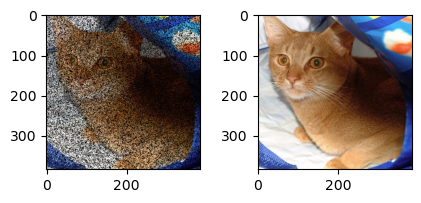

In [3]:
class TransformsTrain:

    def __init__(self, p_range, resize_size=384):
    
        add_noise = AddNoise(p_range)
        transforms = transf.Compose([
            transf.RandomResizedCrop(size=(resize_size,resize_size), scale=(0.5,1.), 
                                     ratio=(0.9,1.1), antialias=True),
            transf.RandomHorizontalFlip(),
            # Efetivamente, a transformação abaixo divide os valores por 255. Foi
            # usado 255.01 para evitar problemas de arredondamento
            transf.Normalize(mean=(0.,0.,0.), std=(255.01,255.01,255.01)), 
        ])  

        self.add_noise = add_noise
        self.transforms = transforms

    def __call__(self, img, target):

        # Precisamos aplicar todas as transformações em ambas as imagens, exceto
        # a transformação de ruído. Por isso primeiro convertemos as imagens para,
        # tensor float32, aplicamos ruído em `img` e depois as demais transformações
        # em ambas as imagens 
        img = transf.functional.pil_to_tensor(img)
        target = transf.functional.pil_to_tensor(target)
        img = img.to(torch.float32)
        target = target.to(torch.float32)
        img = self.add_noise(img)

        img = tv_tensors.Image(img)
        target = tv_tensors.Image(target)
        img, target = self.transforms(img, target)
        img = img.data
        target = target.data

        return img, target

transforms = TransformsTrain((0.5,1.))
img, target = transforms(*ds[0])

fig, axs = plt.subplots(1, 2, figsize=(5,2))
show_img(img, False, axs[0])
show_img(target, False, axs[1])

Para a validação, o ideal seria criarmos um dataset com ruído fixo e salvar as imagens no disco para usar na avaliação da performance. Mas para simplificar vamos também aplicar o ruído cada vez que uma nova imagem for requisitada. Isso pode causar uma variabilidade na performance medida mesmo que o algoritmo esteja melhorando. 

Por exemplo, se na época x forem criadas imagens com pouco ruído, e na época x+1 forem criadas imagens com muito ruído, vai parece que a performance piorou. 

Para diminuir esse problema, no conjunto de validação usaremos o mesmo nível de ruído para todas as imagens.

Também para simplificar iremos redimensionar as imagens de validação para o mesmo tamanho, isso evita ter que definir uma função customizada para criar os batches (collate_fn)

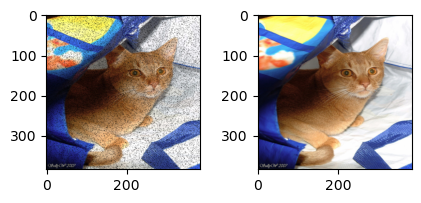

In [4]:
class TransformsEval:

    def __init__(self, p=0.9, resize_size=384):

        transforms = transf.Compose([
            transf.Resize(size=(resize_size, resize_size), antialias=True),
            transf.Normalize(mean=(0.,0.,0.), std=(255.01,255.01,255.01))
        ])

        # Note o mesmo valor de p para mínimo e máximo ruído
        self.add_noise = AddNoise((p,p))
        self.transforms = transforms

    def __call__(self, img, target):

        img = transf.functional.pil_to_tensor(img)
        target = transf.functional.pil_to_tensor(target)
        img = img.to(torch.float32)
        target = target.to(torch.float32)
        img = self.add_noise(img)

        img = tv_tensors.Image(img)
        target = tv_tensors.Image(target)
        img, target = self.transforms(img, target)
        img = img.data
        target = target.data

        return img, target
    
transforms = TransformsEval(0.9)
img, target = transforms(*ds[0])

fig, axs = plt.subplots(1, 2, figsize=(5,2))
show_img(img, False, axs[0])
show_img(target, False, axs[1])